In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, KFold, LeaveOneOut
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, make_scorer, pairwise
import matplotlib.pyplot as plt

In [17]:
np.set_printoptions(threshold=sys.maxsize)
scale = lambda x: StandardScaler().fit_transform(x)
data = pd.read_csv('C:/Users/Daiven/GR_capstone_public/data/ML_data.csv'); del data['Unnamed: 0']
n = data.shape[0]

y_vars = ['AAL','SPEEDMAX','JUMPS','PHYSIOLOAD','EXERTIONS','DISTANCE']
Y_all = np.array(scale(data[y_vars])) # 108 x 6 standardized responses
indicators = pd.get_dummies(data[['HALF','ATHLETE']], dtype=float) #  Date not included
features = data.drop(pd.Index(y_vars + ['ATHLETE','DATE','HALF']), axis=1) 
x_vars = list(indicators.columns) + list(features.columns)

X_full_all = np.c_[np.array(indicators), scale(features)]
X_one = np.ones((n,1))
X_red = np.c_[np.array(indicators), scale(np.array(data.TIME).reshape(-1,1))]

['HALF', 'ATHLETE_Akuel Kot', 'ATHLETE_Brendan Wenzel', 'ATHLETE_Caden Powell', 'ATHLETE_Cam Manyawu', 'ATHLETE_Sam Griffin', 'TIME', 'FLIGHT_TIME', 'JUMP_HEIGHT_IMP_DIS', 'JUMP_HEIGHT_IMP_MOM', 'JUMP_HEIGHT_IMP_MOM_IN_INCHES', 'CONCENTRIC_MEAN_FORCE', 'ECCENTRIC_MEAN_FORCE', 'CONCENTRIC_MEAN_POWER', 'CONCENTRIC_MEAN_POWER_BM', 'MEAN_TAKEOFF_VELOCITY', 'CONCENTRIC_PEAK_VELOCITY', 'VERTICAL_VELOCITY_AT_TAKEOFF', 'TOTAL_WORK', 'VELOCITY_AT_PEAK_POWER', 'ECCENTRIC_DECELERATION_IMPULSE', 'CONCENTRIC_IMPULSE', 'POSITIVE_IMPULSE', 'POSITIVE_TAKEOFF_IMPULSE', 'CONCENTRIC_MEAN_FORCE_BM']


In [18]:
scale = lambda x: StandardScaler().fit_transform(x)
data = pd.read_csv('C:/Users/Daiven/GR_capstone_public/data/ML_data.csv'); del data['Unnamed: 0']
data = data[data['ATHLETE'] == 'Cam Manyawu']
n = data.shape[0]

y_vars = ['AAL','SPEEDMAX','JUMPS','PHYSIOLOAD','EXERTIONS','DISTANCE']
Y = np.array(scale(data[y_vars])) # 108 x 6 standardized responses
indicators = pd.get_dummies(data[['HALF']], dtype=float) #  Date not included
features = data.drop(pd.Index(y_vars + ['ATHLETE','DATE','HALF']), axis=1) 
x_vars = list(indicators.columns) + list(features.columns)

X_full = np.c_[np.array(indicators), scale(features)]
X_one = np.ones((n,1))
X_red = np.c_[np.array(indicators), scale(np.array(data.TIME).reshape(-1,1))]
print(x_vars)

['HALF', 'TIME', 'FLIGHT_TIME', 'JUMP_HEIGHT_IMP_DIS', 'JUMP_HEIGHT_IMP_MOM', 'JUMP_HEIGHT_IMP_MOM_IN_INCHES', 'CONCENTRIC_MEAN_FORCE', 'ECCENTRIC_MEAN_FORCE', 'CONCENTRIC_MEAN_POWER', 'CONCENTRIC_MEAN_POWER_BM', 'MEAN_TAKEOFF_VELOCITY', 'CONCENTRIC_PEAK_VELOCITY', 'VERTICAL_VELOCITY_AT_TAKEOFF', 'TOTAL_WORK', 'VELOCITY_AT_PEAK_POWER', 'ECCENTRIC_DECELERATION_IMPULSE', 'CONCENTRIC_IMPULSE', 'POSITIVE_IMPULSE', 'POSITIVE_TAKEOFF_IMPULSE', 'CONCENTRIC_MEAN_FORCE_BM']


In [6]:
print(X_full.shape)
print(X_red.shape)
print(X_one.shape)
print(Y.shape)

(22, 20)
(22, 2)
(22, 1)
(22, 6)


In [5]:
def response_cv(cv,var):
    if type(var) == str:
        return -np.mean(cv[f'test_{var}'])
    else:
        return [-np.mean(cv[f'test_{var_i}']) for var_i in var]
    
def rmse_score(y_true, y_pred,output_index):
    return mean_squared_error(y_true[:, output_index], y_pred[:, output_index], squared = False)

scorers = {
    f'{y_vars[i]}': make_scorer(rmse_score, output_index=i, greater_is_better=False)
    for i in range(Y.shape[1])
}

In [7]:
loo = LeaveOneOut()
cv_one = cross_validate(MultiOutputRegressor(LinearRegression()), 
                        X_one,Y,cv = loo,scoring = scorers, 
                        return_train_score = False, verbose = 0, n_jobs = -1)
cv_redreg = cross_validate(MultiOutputRegressor(LinearRegression()), 
                           X_red,Y, cv=loo, scoring=scorers,
                           return_train_score=False, verbose = 0, n_jobs = -1)
cv_fullreg = cross_validate(MultiOutputRegressor(LinearRegression()), 
                            X_full, Y, cv=loo, scoring=scorers, return_train_score=False, verbose = 0, n_jobs = -1)

In [8]:
alphas = np.logspace(-4, 4, 100)
folds =  LeaveOneOut()
avg_loocv_rmse = np.zeros((6, len(alphas)))

# Cross validation scores over alpha parameter
for i, alpha in enumerate(alphas):
    rmses = np.zeros(6)
    for response_index in range(6):
        y = Y[:, response_index]
        y_preds = np.zeros(n)
        for train_index, test_index in folds.split(X_full):
            X_train, X_test = X_full[train_index], X_full[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = Ridge(alpha=alpha)
            model.fit(X_train, y_train)
            y_preds[test_index] = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y, y_preds))
        rmses[response_index] = rmse
    avg_loocv_rmse[:, i] = rmses

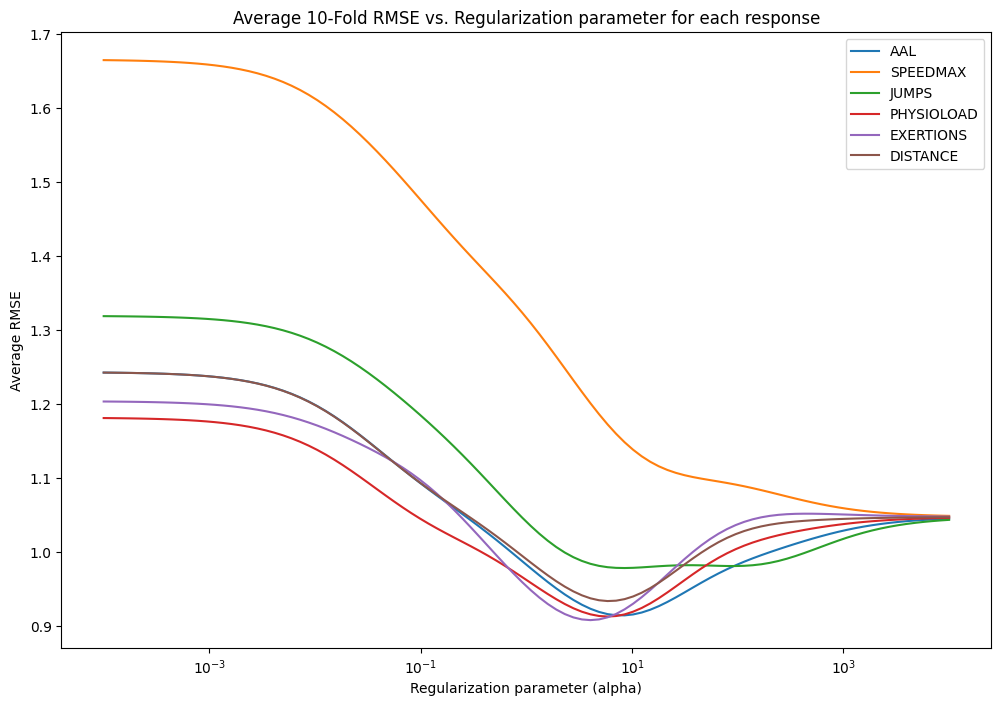

In [9]:
# Plot the average LOOCV RMSE for each response
plt.figure(figsize=(12, 8))
for response_index in range(6):
    plt.plot(alphas, avg_loocv_rmse[response_index], label = y_vars[response_index])
plt.xscale('log')
plt.xlabel('Regularization parameter (alpha)')
plt.ylabel('Average RMSE')
plt.title('Average 10-Fold RMSE vs. Regularization parameter for each response')
plt.legend()
plt.grid(False)
plt.show()

In [10]:
# alpha value for minimum purple value (exertions)
min_index = int(np.squeeze(np.where(avg_loocv_rmse[0] == min(avg_loocv_rmse[0]))))
alpha = alphas[min_index]
print(alpha)

8.497534359086455


In [11]:
# Model switch
# model = MultiOutputRegressor(LinearRegression())
# model = MultiOutputRegressor(GradientBoostingRegressor())
# model = RandomForestRegressor()
# model = RegressorChain(LinearRegression())
model = Ridge(alpha = alpha)
# model = PLSRegression(5,scale=False)
# model = KernelRidge(kernel="poly")

In [12]:
rfe_model = RFECV(model, step=1, verbose=0, min_features_to_select=1,
                  cv=loo, n_jobs=-1, scoring='neg_root_mean_squared_error')
selector = rfe_model.fit(X_full, Y)
x_cutnames = [string for string, flag in zip(x_vars, selector.support_) if flag]
x_cutnames

['HALF', 'TIME', 'POSITIVE_IMPULSE']

In [19]:
cv_red = cross_validate(model, X_red,Y, cv=loo, scoring=scorers, 
                        return_train_score=False,verbose = 0,n_jobs = -1)
cv_full = cross_validate(model, X_full,Y, cv=loo, scoring=scorers, 
                         return_train_score=False,verbose = 0,n_jobs = -1)

X_cut = X_full[:,selector.support_]
cv_cut = cross_validate(model, X_cut,Y, cv=loo, scoring=scorers, 
                        return_train_score=False,verbose = 0,n_jobs = -1)
print(f'Response Order: {y_vars}')
print('')
print(f'Intercept Only Regression: \n{response_cv(cv_one,y_vars)}')
print(f'Kinexon Only Regression: \n{response_cv(cv_redreg,y_vars)}')
print(f'Full Model Regression: \n{response_cv(cv_fullreg,y_vars)}')
print('')
print(f'Kinexon Only Model: \n{response_cv(cv_red,y_vars)}')
print(f'Full Model: \n{response_cv(cv_full,y_vars)}')
print(f'Reduced Model: \n{response_cv(cv_cut,y_vars)}')

Response Order: ['AAL', 'SPEEDMAX', 'JUMPS', 'PHYSIOLOAD', 'EXERTIONS', 'DISTANCE']

Intercept Only Regression: 
[0.925755932879762, 0.8001382822238567, 0.905616029864348, 0.9060549990459659, 0.9440866601923912, 0.908449399848542]
Kinexon Only Regression: 
[0.754012042447216, 0.8145028694884289, 0.9218626158949497, 0.7034209151791905, 0.7788534762500052, 0.698118614382842]
Full Model Regression: 
[0.9707744036558498, 1.468518810921055, 1.1205453472068934, 0.9597113231827469, 1.0006965552417073, 1.0079199762292401]

Kinexon Only Model: 
[0.7759545000619792, 0.7694439428774005, 0.9007607317359817, 0.7494415622936917, 0.8113605675978527, 0.746709663637946]
Full Model: 
[0.7316602617772094, 0.9493044152828638, 0.8094760907983929, 0.7095648156429719, 0.7545283813071841, 0.7270221426433694]
Reduced Model: 
[0.6854015365720325, 0.7973620956014948, 0.7312747191857579, 0.6609789088869646, 0.8130183837241788, 0.6811076706613607]


In [34]:
fit_model = model.fit(X_cut,Y)
coefs = pd.DataFrame(fit_model.coef_)
coefs.index = y_vars
coefs.columns = x_cutnames
print(coefs)

                HALF      TIME  POSITIVE_IMPULSE
AAL         0.176350  0.332630         -0.303786
SPEEDMAX    0.119388  0.279527          0.049095
JUMPS       0.164831  0.069999         -0.397266
PHYSIOLOAD  0.198281  0.337442         -0.289280
EXERTIONS   0.245744  0.265832         -0.157260
DISTANCE    0.216262  0.338453         -0.250674


InvalidIndexError: (0, slice(None, None, None))

In [31]:
np.mean(np.array(data[y_vars]),axis=0).reshape(-1,1)

array([[ 334.69840577],
       [   6.56849723],
       [  17.95454545],
       [ 461.3161845 ],
       [  42.81818182],
       [1932.75567486]])

array([4.18819865e+03, 1.89087288e-01, 1.47706612e+01, 8.15268989e+03,
       1.27239669e+02, 1.32408746e+05])